In [1]:
import pandas as pd
import torch


### For Reproducibility

In [2]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disables fast auto-tuning

# Set seed for reproducibility
set_seed(42)


In [4]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

# Prepare data

In [3]:
%%time

# df1 = pd.read_pickle('data/methyl_scores_v1_HM450k_1.pkl', compression="bz2")
# df2 = pd.read_pickle('data/methyl_scores_v1_HM450k_2.pkl', compression="bz2")
# df3 = pd.read_pickle('data/methyl_scores_v1_HM450k_3.pkl', compression="bz2")
# df4 = pd.read_pickle('data/methyl_scores_v1_HM450k_4.pkl', compression="bz2")
# df5 = pd.read_pickle('data/methyl_scores_v1_HM450k_5.pkl', compression="bz2")
# df = pd.concat([df1, df2, df3, df4, df5], axis=0)
df = pd.read_pickle('../data/v1/methyl_scores_v1_HM450k_4.pkl', compression="bz2")



CPU times: user 52 s, sys: 383 ms, total: 52.4 s
Wall time: 52.6 s


In [5]:
df.shape

(993, 485590)

In [7]:
df[['id', 'geo_accession', 'title', 'sex', 'age', 'race', 'disease',
       'tissue', 'geo_platform', 'inferred_sex', 'inferred_age_Hannum',
       'inferred_age_SkinBlood', 'inferred_age_Horvath353']].head()

,id,geo_accession,title,sex,age,race,disease,tissue,geo_platform,inferred_sex,inferred_age_Hannum,inferred_age_SkinBlood,inferred_age_Horvath353
GSM5931643,66724,GSM5931643,Pre-intervention monocyte genomic DNA methylat...,male,None,None,diabetes mellitus,monocyte,GPL13534,M,NaN,NaN,NaN
GSM5931644,66725,GSM5931644,Pre-intervention monocyte genomic DNA methylat...,female,None,None,diabetes mellitus,monocyte,GPL13534,F,NaN,NaN,NaN
GSM5931645,66726,GSM5931645,Pre-intervention monocyte genomic DNA methylat...,male,None,None,diabetes mellitus,monocyte,GPL13534,M,NaN,NaN,NaN
GSM5931646,66727,GSM5931646,Pre-intervention monocyte genomic DNA methylat...,female,None,None,diabetes mellitus,monocyte,GPL13534,F,NaN,NaN,NaN
GSM5931647,66728,GSM5931647,Pre-intervention monocyte genomic DNA methylat...,male,None,None,diabetes mellitus,monocyte,GPL13534,M,NaN,NaN,NaN


# Prepare the data

In [8]:
# Assuming `df` is your DataFrame
metadata_columns = ['id', 'geo_accession', 'title', 'sex', 'age', 'race',
                    'tissue', 'geo_platform', 'inferred_age_Hannum',
                    'inferred_age_SkinBlood', 'inferred_age_Horvath353']  # list of metadata columns

label_column = 'disease'  # column with target values for classification/regression
condition_column = 'inferred_sex'
numerical_data = df.drop(metadata_columns + [label_column] + [condition_column], axis=1)  # features for training



Fill in the NA values in the `label_column`

In [9]:
default_value = 'no_label'
df[label_column].fillna(default_value, inplace=True)

labels = df[label_column]  # target/label for model training
conditions = df[condition_column]  # target/label for model training

/tmp/7394363.1.gpu.q/ipykernel_477250/744962163.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[label_column].fillna(default_value, inplace=True)


In [10]:
labels.value_counts()

disease
control                            378
Crohn's disease                    177
fetal alcohol spectrum disorder    112
ulcerative colitis                  87
glioblastoma                        72
pre-eclampsia                       71
no_label                            45
epilepsy                            30
diabetes mellitus                   16
pulmonary hypertension               5
Name: count, dtype: int64

## Detect and drop unreliable columns

In [11]:
# numerical_data.isna().sum(axis=0)

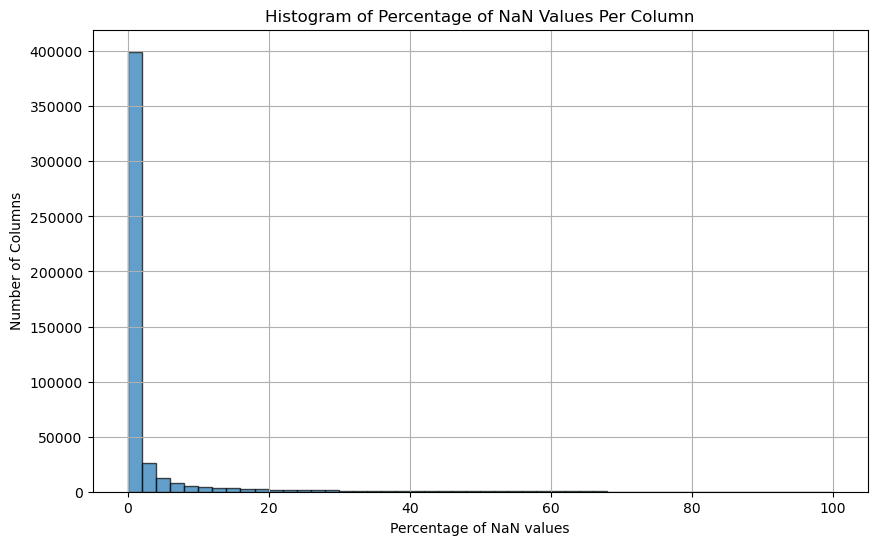

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# # Calculate the percentage of NaN values in each column
nan_percentage = numerical_data.isna().sum(axis=0) / numerical_data.shape[0] * 100

# Plot the histogram of the percentage of NaN values per column
plt.figure(figsize=(10, 6))
plt.hist(nan_percentage, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histogram of Percentage of NaN Values Per Column")
plt.xlabel("Percentage of NaN values")  
plt.ylabel("Number of Columns")
plt.grid(True)

plt.show()


In [13]:
print(f"more than 1% NaN: {(nan_percentage>1).sum()}")
print(f"more than 5% NaN: {(nan_percentage>5).sum()}")
print(f"more than 10% NaN: {(nan_percentage>10).sum()}")
print(f"more than 15% NaN: {(nan_percentage>15).sum()}")
print(f"more than 20% NaN: {(nan_percentage>20).sum()}")
print(f"more than 30% NaN: {(nan_percentage>30).sum()}")


more than 1% NaN: 130898
more than 5% NaN: 53247
more than 10% NaN: 34701
more than 15% NaN: 25509
more than 20% NaN: 19363
more than 30% NaN: 11843


In [14]:
# Select subset of columns where NaN percentage is less than 10%
selected_columns = nan_percentage[nan_percentage < 10].index.tolist()

# Create a new DataFrame with the selected columns
numerical_data_filtered = numerical_data[selected_columns]



In [13]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Convert categorical labels to one-hot vectors
labels_onehot = onehot_encoder.fit_transform(labels.values.reshape(-1, 1))



In [14]:
labels_onehot.shape

(11694, 27)

In [17]:
labels_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
%%time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.preprocessing import StandardScaler

# Start by assuming your data is unscaled
numerical_data_filtered = numerical_data_filtered.values  # Assuming this is your data
labels_onehot = labels_onehot  # Assuming these are your labels

# Convert one-hot encoded labels to class indices
labels_class = np.argmax(labels_onehot, axis=1)  # Convert one-hot to class labels

# Stratified shuffle split (30% test set, 70% train) based on class indices
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in splitter.split(numerical_data_filtered, labels_class):
    X_train, X_temp = numerical_data_filtered[train_index], numerical_data_filtered[test_index]
    y_train, y_temp = labels_onehot[train_index], labels_onehot[test_index]  # Use one-hot labels for actual training

# Split the temp set into validation and test sets (15% val, 15% test)
splitter_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in splitter_val_test.split(X_temp, np.argmax(y_temp, axis=1)):  # Use class labels here
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


CPU times: user 55.6 s, sys: 4.57 s, total: 1min
Wall time: 1min


In [19]:
%%time
# Now scale the data
SCALE = True
if SCALE:
    scaler = StandardScaler()

    # Fit the scaler only on the training data
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply the same scaler to the validation and test sets
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
else:
    # If scaling is turned off, use the raw data
    X_train_scaled = X_train
    X_val_scaled = X_val
    X_test_scaled = X_test
    

In [21]:
%%time
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# This saves both X (features) and y (labels) for train, val, and test datasets
from pathlib import Path
dataset_path = 'data/m1/'
directory_path = Path(dataset_path)
directory_path.mkdir(parents=True, exist_ok=True)

torch.save(train_dataset.tensors, f'{dataset_path}train_dataset_tensors.pt')  # Saves (X_train, y_train)
torch.save(val_dataset.tensors, f'{dataset_path}val_dataset_tensors.pt')      # Saves (X_val, y_val)
torch.save(test_dataset.tensors, f'{dataset_path}test_dataset_tensors.pt')    # Saves (X_test, y_test)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))

# Check the stratified split
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (8185, 451747)
Validation set size: (1754, 451747)
Test set size: (1755, 451747)
CPU times: user 10.7 s, sys: 11 s, total: 21.8 s
Wall time: 18.5 s


# Load Tensor Dataset

In [106]:
import os

# Set the environment variable inside the script
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


In [90]:
dataset_path = 'data/m1/'

# This loads both X (features) and y (labels) from the saved files
train_tensors = torch.load(f'{dataset_path}train_dataset_tensors.pt')  # Loads (X_train, y_train)
val_tensors = torch.load(f'{dataset_path}val_dataset_tensors.pt')      # Loads (X_val, y_val)
test_tensors = torch.load(f'{dataset_path}test_dataset_tensors.pt')    # Loads (X_test, y_test)

# Recreate the TensorDataset
train_dataset = TensorDataset(*train_tensors)
val_dataset = TensorDataset(*val_tensors)
test_dataset = TensorDataset(*test_tensors)



/tmp/7390029.1.gpu.q/ipykernel_775322/2586274531.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_tensors = torch.load(f'{dataset_path}train_dataset_tensors.pt')  #

In [91]:
# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))

# Build VAE

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[2048,1024,512], dropout_rate=0.2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder_layers = self.build_layers(input_dim, hidden_dims, dropout_rate)
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)  # for mean
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)  # for log variance
        
        # Decoder
        decoder_hidden_dims = hidden_dims[::-1]
        self.decoder_layers =self.build_layers(latent_dim, decoder_hidden_dims, dropout_rate)
        self.fc_output = nn.Linear(hidden_dims[0], input_dim)
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def build_layers(self, input_dim, hidden_dims, dropout_rate):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def encode(self, x):
        h = self.encoder_layers(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Check if logvar has NaN or Inf values
        if torch.isnan(logvar).any() or torch.isinf(logvar).any():
            print(f"NaN or Inf detected in logvar: logvar={logvar}")
        
        # Clamp logvar to prevent extreme values
        logvar = torch.clamp(logvar, min=-10, max=10)
        
        # Calculate std from logvar
        std = torch.exp(0.5 * logvar)
        
        # Check if std has NaN or Inf values
        if torch.isnan(std).any() or torch.isinf(std).any():
            print(f"NaN or Inf detected in std computation: std={std}")
        
        # Sample from the latent space
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        # Check if z has NaN or Inf values
        if torch.isnan(z).any() or torch.isinf(z).any():
            print(f"NaN or Inf detected in z computation: z={z}")
        
        return z

    def decode(self, z):
        h = self.decoder_layers(z)
        # h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc_output(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def get_latent_embedding(self, x):
        """
        Method to get the latent embedding (the `z` vector) for an input.
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)  # this is the embedding
        return z


In [8]:
class VAE_Lightning(pl.LightningModule):
    def __init__(self, input_dim=485577, latent_dim=128, hidden_dims=[2048, 1024, 512], dropout_rate=0.2, lr=1e-6):
        super(VAE_Lightning, self).__init__()
        
        self.save_hyperparameters()  # Save hyperparameters for checkpointing

        self.model = VAE(input_dim, latent_dim, hidden_dims, dropout_rate)
        self.lr = lr
    
    def forward(self, x):
        mu, logvar = self.model.encode(x)
        z = self.model.reparameterize(mu, logvar)
        return z, mu, logvar

    def get_latent_embedding(self, x):
        return self.model.get_latent_embedding(x)
        
    def training_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)  # mask where values are not NaN

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Training loss: {loss.item()}")

        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    
    def validation_step(self, batch, batch_idx):
        x, _ = batch

        # Step 1: Create mask before replacing NaN values
        mask = ~torch.isnan(x)

        # Step 2: Replace NaNs with zero or another neutral value for forward pass
        x_filled = replace_nan_with_mean(x)
        # x_filled = torch.nan_to_num(x, nan=0.0)

        # Step 3: Pass through the model with filled values
        z, mu, logvar = self.forward(x_filled)
        x_hat, _, _ = self.model(x_filled)

        # Step 4: Use the original x (with NaNs) and mask to calculate the loss
        loss = self._vae_loss(x, x_hat, mu, logvar, mask)
        print(f"Validation loss: {loss.item()}")

        self.log('val_loss', loss, on_step=False, on_epoch=True)
  

    def _vae_loss(self, original_x, x_hat, mu, logvar, mask):
        # Apply mask to ignore NaN values in the loss calculation
        recon_loss = F.mse_loss(x_hat[mask], original_x[mask], reduction='mean')
    
        # Scale the KL divergence to balance the losses
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_loss = kl_loss / original_x.shape[0]  # Normalize by batch size or apply weighting
    
        return recon_loss + kl_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [9]:
from pytorch_lightning.callbacks import Callback

class LossHistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the loss for the last training epoch from the logs
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the loss for the last validation epoch from the logs
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())



def replace_nan_with_mean(x):
    # Calculate the column-wise mean, ignoring NaNs
    col_mean = torch.nanmean(x, dim=0)
    
    # Find where NaN values are located
    nan_mask = torch.isnan(x)
    
    # Replace NaNs with the corresponding column means
    x[nan_mask] = torch.take(col_mean, nan_mask.nonzero()[:, 1])
    
    # Check if there are still NaN or Inf values
    if torch.isnan(x).any() or torch.isinf(x).any():
        print("NaN or Inf detected in the input data after imputation!")
    
    return x

## Train VAE

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
%%time
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer, loggers

# Create a logger
logger = loggers.CSVLogger('lightning_logs/', name='m1_vae')


pl.seed_everything(42)

# Initialize the VAE Lightning model
input_dim = X_train_tensor.shape[1]  # The number of input features
latent_dim = 256  # Latent dimension size, can be tuned
hidden_dims = [2048, 1024, 512]
dropout_rate = 0.2
lr = 1e-6

model = VAE_Lightning(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    dropout_rate=dropout_rate,
    lr=lr)

# Training
loss_history_callback = LossHistoryCallback()
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    dirpath=f'{logger.save_dir}/{logger.name}/version_{logger.version}/checkpoints/',
    filename='m1-vae-{epoch:02d}-{val_loss:.2f}'
    )

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

trainer = pl.Trainer(
    max_epochs=200,
    gradient_clip_val=0.5,  # Clip gradients to avoid explosion
    callbacks=[checkpoint_callback, early_stopping_callback, loss_history_callback],
    precision=32,
    accelerator='gpu',          # Use 'gpu' or 'cpu'
    devices=1 if torch.cuda.is_available() else 'auto',  # Use 1 GPU or CPU ('auto' will pick the appropriate one)
    deterministic=True,  # Ensure reproducibility
    logger=logger
)
trainer.fit(model, train_loader, val_loader)


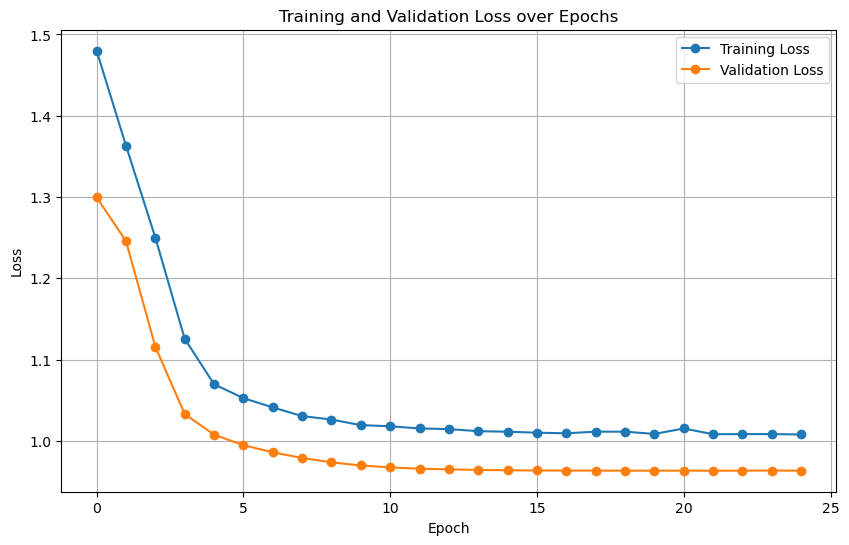

In [11]:
import matplotlib.pyplot as plt

# Assume 'df_logs' is your DataFrame with the logs
# Drop the rows with NaN values for plotting each loss curve separately
df_logs = pd.read_csv("lightning_logs/m1_vae/version_0/metrics.csv")

# Extract relevant columns
epochs = df_logs['epoch'].unique()  # Get unique epoch values
train_loss = df_logs['train_loss'].dropna()  # Drop NaN values for train loss
val_loss = df_logs['val_loss'].dropna()      # Drop NaN values for validation loss

# Plot the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss', marker='o')
plt.plot(epochs[:len(val_loss)], val_loss, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import yaml

# Load the hyperparameters from the hparams.yaml file
hparams_path = 'lightning_logs/m1_vae/version_0/hparams.yaml'  # Replace with the correct path
with open(hparams_path) as file:
    hparams = yaml.safe_load(file)

print(hparams)  # To inspect the hyperparameters


{'dropout_rate': 0.2, 'hidden_dims': [2048, 1024, 512], 'input_dim': 451747, 'latent_dim': 256, 'lr': 1e-06}


In [16]:
from pytorch_lightning import Trainer

checkpoint_path = "lightning_logs/m1_vae/version_0/checkpoints/m1-vae-epoch=21-val_loss=0.96.ckpt"
vae_model = VAE_Lightning.load_from_checkpoint(
    checkpoint_path,
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    **hparams
    )

vae_model.eval()

VAE_Lightning(
  (model): VAE(
    (encoder_layers): Sequential(
      (0): Linear(in_features=451747, out_features=2048, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=2048, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=512, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (fc_mu): Linear(in_features=512, out_features=256, bias=True)
    (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
    (decoder_layers): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=1024, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=1024, out_features=2048, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.2, inplace=False)
    )
    (

In [92]:
def get_latent_embeddings(model, dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            x,y = batch

            x = x.to(device)
            y = y.to(device)
            
            # Replace NaNs with zero or another neutral value for forward pass
            x_filled = replace_nan_with_mean(x)
            # x_filled = torch.nan_to_num(x, nan=0.0)
            
            z, _, _ = model.forward(x_filled)
            embeddings.append(z)
            labels.append(y)
        
        embeddings = torch.cat(embeddings, dim=0)
        labels = torch.cat(labels, dim=0)

    return embeddings, labels

train_embeddings, train_labels = get_latent_embeddings(vae_model, train_loader)
val_embeddings, val_labels = get_latent_embeddings(vae_model, val_loader)
test_embeddings, test_labels = get_latent_embeddings(vae_model, test_loader)

        

In [93]:
# import umap
# import matplotlib.pyplot as plt
# import numpy as np

# # Combine train and validation embeddings
# combined_embeddings = torch.cat([train_embeddings, val_embeddings], dim=0).cpu().numpy()
# combined_labels = torch.cat([train_labels, val_labels], dim=0).cpu().numpy()
# # Convert one-hot encoded labels to class indices using argmax
# combined_labels_1d = combined_labels.argmax(axis=1)  # Find the index of the maximum (1) in each one-hot vector

# # Fit UMAP on the combined embeddings
# umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
# combined_umap = umap_model.fit_transform(combined_embeddings)

# # Plot UMAP embeddings (train + validation)
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(combined_umap[:, 0], combined_umap[:, 1], c=combined_labels_1d, cmap='Spectral', s=10, alpha=0.8)
# plt.colorbar(scatter)
# plt.title('UMAP Projection of Train + Validation Embeddings')
# plt.show()


In [94]:
# # Convert test one-hot encoded labels to class indices
# test_labels_1d = test_labels.cpu().numpy().argmax(axis=1)

# # Project test embeddings onto the UMAP space
# test_umap = umap_model.transform(test_embeddings.cpu().numpy())

# # Plot the test UMAP embeddings
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(test_umap[:, 0], test_umap[:, 1], c=test_labels_1d, cmap='Spectral', s=10, alpha=0.8)
# plt.colorbar(scatter)
# plt.title('UMAP Projection of Test Embeddings')
# plt.show()


# MLP building

In [162]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam

class MLP(pl.LightningModule):
    def __init__(self, input_dim, layer_dims, num_classes, dropout_rate=0.2, lr=1e-3, class_weights=None):
        """
        :param input_dim: Number of input features (e.g., from VAE embeddings)
        :param layer_dims: List of integers defining the number of units in each layer
        :param num_classes: Number of output classes for classification (should match the number of columns in one-hot labels)
        :param dropout_rate: Dropout rate to be applied after each layer
        :param lr: Learning rate
        """
        super(MLP, self).__init__()
        
        self.save_hyperparameters()  # Save hyperparameters for checkpointing

        # Store learning rate
        self.lr = lr
        # self.class_weights = class_weights  # Add class weights
        
        # Store the class weights and move them to the right device in the forward pass
        self.register_buffer('class_weights', class_weights)
        
        # Build the network layers
        layers = []
        current_dim = input_dim

        for dim in layer_dims:
            layers.append(nn.Linear(current_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = dim

        # Output layer for one-hot encoded labels (num_classes)
        layers.append(nn.Linear(current_dim, num_classes))  # Output layer with num_classes
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch  # y is class index (not one-hot encoded)
        y_hat = self(x)
    
        # Use CrossEntropyLoss for single-label classification with class weighting
        loss = F.cross_entropy(y_hat, y, weight=self.class_weights.to(self.device))
        # loss = F.cross_entropy(y_hat, y)
    
        print(f"Training loss: {loss.item()}")
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch  # y is class index (not one-hot encoded)
        y_hat = self(x)
    
        val_loss = F.cross_entropy(y_hat, y, weight=self.class_weights.to(self.device))
        # val_loss = F.cross_entropy(y_hat, y)
    
        print(f"Validation loss: {val_loss.item()}")
        self.log('val_loss', val_loss, on_step=False, on_epoch=True)
        return val_loss
    
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)

In [163]:

labels_class = np.argmax(train_tensors[1], axis=1)  # Convert one-hot to class labels
labels_class = labels_class.numpy()

unique, counts = np.unique(labels_class, return_counts=True)
# unique, counts = unique.tolist(), counts.tolist()
# Convert back to tensor if needed, or just print the results
value_counts = dict(zip(unique, counts))
class_counts = counts
class_counts

array([ 843,   80,  124,    6,  671,   35, 3766,   15,  100,   21,   78,
         85,   50,   73,   40,   28,   78,  168, 1030,   21,  185,   50,
          3,  503,   26,   45,   61])

In [164]:
import torch
from torch.utils.data import WeightedRandomSampler

# Assume you have a tensor of class frequencies
# class_counts = torch.tensor([181, 17, 27, 1, 144, 7, 807, 3, 22, 4, 17, 19, 11, 16, 8, 6, 17, 36, 221, 4, 40, 10, 1, 108, 5, 10, 13])  # example
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize weights
class_weights = torch.tensor(class_weights).to(torch.float32)

class_weights


tensor([1.2265e-03, 1.2924e-02, 8.3380e-03, 1.7232e-01, 1.5409e-03, 2.9540e-02,
        2.7454e-04, 6.8928e-02, 1.0339e-02, 4.9234e-02, 1.3255e-02, 1.2164e-02,
        2.0678e-02, 1.4163e-02, 2.5848e-02, 3.6926e-02, 1.3255e-02, 6.1543e-03,
        1.0038e-03, 4.9234e-02, 5.5887e-03, 2.0678e-02, 3.4464e-01, 2.0555e-03,
        3.9766e-02, 2.2976e-02, 1.6949e-02])

## Train MLP

In [165]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Convert one-hot encoded labels to class indices
targets = torch.argmax(train_labels, dim=1)  # 'targets' contains class indices

# Count how many samples belong to each class
class_sample_count = torch.bincount(targets)  # Class counts for each class in targets

# Compute weights for each class
weights = torch.sqrt(1.0 / class_sample_count.float())  # Inverse of class frequency

# Assign weights to each sample based on its class
samples_weight = torch.tensor([weights[t] for t in targets])

# Define a WeightedRandomSampler with the computed sample weights
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

# # Create DataLoader with the sampler
# train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)


In [168]:
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer, loggers
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Assuming train_embeddings, val_embeddings, test_embeddings are the VAE embeddings
# and train_labels, val_labels, test_labels are one-hot encoded (not converting them back to class indices)

# # Create TensorDatasets
# train_dataset = TensorDataset(train_embeddings, train_labels)
# val_dataset = TensorDataset(val_embeddings, val_labels)
# test_dataset = TensorDataset(test_embeddings, test_labels)

# Convert one-hot encoded labels to class indices using argmax
train_labels_indices = torch.argmax(train_labels, dim=1)
val_labels_indices = torch.argmax(val_labels, dim=1)
test_labels_indices = torch.argmax(test_labels, dim=1)

# Now, use the class indices labels instead of one-hot encoded labels in your dataset
train_dataset = TensorDataset(train_embeddings, train_labels_indices)
val_dataset = TensorDataset(val_embeddings, val_labels_indices)
test_dataset = TensorDataset(test_embeddings, test_labels_indices)




# Create DataLoaders
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, worker_init_fn=lambda _: np.random.seed(42))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=lambda _: np.random.seed(42))

pl.seed_everything(42)

# Create a logger
logger = loggers.CSVLogger('lightning_logs/', name='m1_mlp')


# Define MLP layer dimensions
layer_dims = [64, 32]  # Example of multiple hidden layers
dropout_rate=0.6
lr=1e-4

# Initialize the MLP model with dropout
mlp_model = MLP(input_dim=train_embeddings.shape[1],  # Input dimension should match VAE embeddings size
                layer_dims=layer_dims, 
                num_classes=train_labels.shape[1],  # Number of output classes (same as number of columns in one-hot encoded labels)
                dropout_rate=dropout_rate, 
                lr=lr,
                class_weights=class_weights)

# Create the loss history callback
loss_history_callback = LossHistoryCallback()
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,
    mode='min',
    dirpath=f'{logger.save_dir}/{logger.name}/version_{logger.version}/checkpoints/',
    filename='m1-mlp-{epoch:02d}-{val_loss:.2f}'
    )

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback, loss_history_callback],
    accelerator='gpu',
    precision=32,
    devices=1 if torch.cuda.is_available() else 'auto',
    deterministic=True,  # Ensure reproducibility
    logger=logger,
    )

# Train the MLP model
trainer.fit(mlp_model, train_loader, val_loader)


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 19.4 K | train
---------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 128/128 [00:00<00:00, 158.33it/s, v_num=20]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/28 [00:00<?, ?it/s]Validation loss: 3.270726203918457

Validation DataLoader 0:   4%|▎         | 1/28 [00:00<00:00, 143.11it/s]Validation loss: 3.2547619342803955

Validation DataLoader 0:   7%|▋         | 2/28 [00:00<00:00, 174.09it/s]Validation loss: 3.389413833618164

Validation DataLoader 0:  11%|█         | 3/28 [00:00<00:00, 181.16it/s]Validation loss: 3.359450340270996

Validation DataLoader 0:  14%|█▍        | 4/28 [00:00<00:00, 189.71it/s]Validation loss: 3.2584776878356934

Validation DataLoader 0:  18%|█▊        | 5/28 [00:00<00:00, 191.30it/s]Validation loss: 3.347144603729248

Validation DataLoader 0:  21%|██▏       | 6/28 [00:00<00:00, 195.79it/s]Validation loss: 3.266162633895874

Validation DataLoader 0:  25%|██▌       | 7/28 [00:00<00:00, 199.16it/s]Validation loss: 3.303565740585327

Validation DataLoader 0:  2

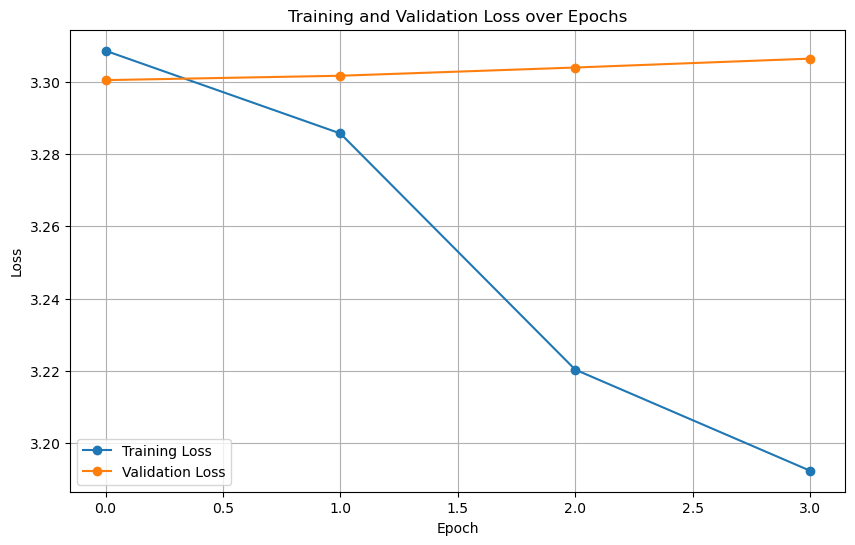

In [169]:
import matplotlib.pyplot as plt

# Assume 'df_logs' is your DataFrame with the logs
# Drop the rows with NaN values for plotting each loss curve separately
df_logs = pd.read_csv("lightning_logs/m1_mlp/version_20/metrics.csv")

# Extract relevant columns
epochs = df_logs['epoch'].unique()  # Get unique epoch values
train_loss = df_logs['train_loss'].dropna()  # Drop NaN values for train loss
val_loss = df_logs['val_loss'].dropna()      # Drop NaN values for validation loss

# Plot the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss', marker='o')
plt.plot(epochs[:len(val_loss)], val_loss, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [147]:
import torch

# Get predictions from the MLP model
def get_predictions(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Move model to the correct device (e.g., GPU)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            x, labels = batch
            
            # Move data to the same device as the model
            x = x.to(device)
            labels = labels.to(device)
            
            # Get logits from the model
            logits = model(x)
            
            # Get predicted classes
            preds = torch.argmax(logits, dim=1)
            
            # Append predictions and labels
            all_preds.append(preds.cpu())  # Move predictions back to CPU
            all_labels.append(labels.cpu())  # Move labels back to CPU

    # Concatenate all predictions and labels
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    return all_preds, all_labels

# Define the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get predictions and labels on the test set
test_preds, labels_test = get_predictions(mlp_model, test_loader, device)


In [148]:
# import yaml

# # Load the hyperparameters from the hparams.yaml file
# hparams_path = 'lightning_logs/m1_mlp/'  # Replace with the correct path
# with open(hparams_path) as file:
#     hparams = yaml.safe_load(file)

# print(hparams)  # To inspect the hyperparameters
# from pytorch_lightning import Trainer

# checkpoint_path = "lightning_logs/m1_vae/version_0/checkpoints/m1-vae-epoch=21-val_loss=0.96.ckpt"
# vae_model = VAE_Lightning.load_from_checkpoint(
#     checkpoint_path,
#     map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
#     **hparams
#     )

# vae_model.eval()

In [149]:
import numpy as np
from sklearn.metrics import classification_report

# Convert one-hot encoded labels back to class indices
# test_labels_argmax = np.argmax(test_labels, axis=1)

# Generate class names for 27 classes
target_names = [f"Class {i}" for i in range(27)]

# Generate the classification report using class labels
report = classification_report(labels_test, test_preds, target_names=target_names, zero_division=0)


# Print the report
print(report)


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       181
     Class 1       0.01      0.76      0.02        17
     Class 2       0.00      0.00      0.00        27
     Class 3       0.00      0.00      0.00         1
     Class 4       0.00      0.00      0.00       144
     Class 5       0.00      0.00      0.00         7
     Class 6       0.00      0.00      0.00       807
     Class 7       0.00      0.00      0.00         3
     Class 8       0.00      0.00      0.00        22
     Class 9       0.00      0.00      0.00         4
    Class 10       0.00      0.00      0.00        17
    Class 11       0.00      0.00      0.00        19
    Class 12       0.00      0.00      0.00        11
    Class 13       0.00      0.00      0.00        16
    Class 14       0.00      0.00      0.00         8
    Class 15       0.00      0.00      0.00         6
    Class 16       0.00      0.00      0.00        17
    Class 17       0.00    

In [33]:
train_loader

In [57]:
train_dataset

In [69]:
train_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [70]:
val_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [71]:
test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)